In [1]:
import nltk
from nltk.tokenize import RegexpTokenizer, sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.autograd import Variable

from torch.utils.tensorboard import SummaryWriter

from sklearn.decomposition import PCA
import numpy as np
import plotly.graph_objs as go
from datetime import datetime

In [2]:
writer = SummaryWriter('runs/ngram_model_log_'+datetime.now().strftime("%d-%m-%Y-%H-%M-%S"))

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ivana\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ivana\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
wordnet_lemmatizer = WordNetLemmatizer()

In [6]:
# hyperparameters
CONTEXT_SIZE = 3
EMBEDDING_DIM = 100

In [8]:
# create vocabular
with open('text.txt','r') as f:
    text = f.read().lower()
    
    sentences = sent_tokenize(text)
    
    vocabulary = set()
    for sentence in sentences:
        words = nltk.word_tokenize(sentence)
        for word in words:
            if word.isalpha():
                vocabulary.add(wordnet_lemmatizer.lemmatize(word))

In [9]:
print(sentences[:3])

['mr and mrs dursley, of number four, privet drive, were proud to say that they were perfectly normal, thank you very much.', "they were the last people you'd expect to be involved in anything strange or mysterious, because they just didn't hold with such nonsense.", 'mr dursley was the director of a firm called grunnings, which made drills.']


In [10]:
print(list(vocabulary)[:3])

['beefy', 'owl', 'bonfire']


In [11]:
word_to_ix = {word: i for i, word in enumerate(vocabulary)}

In [12]:
def process_words(words):
    words_processed = []
    for word in words:
        if word.isalpha():
            words_processed.append(wordnet_lemmatizer.lemmatize(word))
    return words_processed

In [13]:
# create ngrams
ngrams = []
for sentence in sentences:
    words = nltk.word_tokenize(sentence)
    words_processed = process_words(words)
    ngram = []
    target = None
    count_ngram = 0
    for idx,word in enumerate(words_processed):
        if idx+CONTEXT_SIZE<len(words_processed):
            while count_ngram<CONTEXT_SIZE:
                ngram.append(words_processed[idx+count_ngram])
                count_ngram += 1
            #print(ngram)
            target = words_processed[idx+CONTEXT_SIZE]
            ngrams.append((ngram[::-1], target))
            count_ngram = 0
            ngram = []

In [14]:
print(ngrams[:3])

[(['mr', 'and', 'mr'], 'dursley'), (['dursley', 'mr', 'and'], 'of'), (['of', 'dursley', 'mr'], 'number')]


In [15]:
print(len(ngrams))

3468


In [16]:
# model architecture
class NgramEmbedding(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NgramEmbedding, self).__init__()
        self.hidden_size = 256
        self.num_layers = 1
        self.context_size = context_size
        
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, num_layers=self.num_layers, hidden_size=self.hidden_size)
        self.linear1 = nn.Linear(context_size*self.hidden_size, 256)
        self.linear2 = nn.Linear(256, 512)
        self.linear3 = nn.Linear(512, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs.view(1,-1))#.view(len(inputs),1,-1)
        h_0 = Variable(torch.zeros(self.num_layers, embeds.size(1), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, embeds.size(1), self.hidden_size))
        out, (hn, cn) = self.lstm(embeds, (h_0, c_0))
        out = F.relu(self.linear1(out.view(1, self.context_size*self.hidden_size)))
        out = F.relu(self.linear2(out))
        out = self.linear3(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

In [17]:
model = NgramEmbedding(len(vocabulary), EMBEDDING_DIM, CONTEXT_SIZE)
print(model)

NgramEmbedding(
  (embeddings): Embedding(1052, 100)
  (lstm): LSTM(100, 256)
  (linear1): Linear(in_features=768, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=1052, bias=True)
)


In [18]:
# hyperparameters
losses = []
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [ ]:
# model training
running_loss = 0.0
for epoch in range(1000):
    total_loss = 0
    for i, (context, target) in enumerate(ngrams, 0):
        
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
        model.zero_grad()

        log_probs = model(context_idxs)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        running_loss += loss.item()
        if i % 1000 == 999:    # every 1000 mini-batches...

            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(ngrams) + i)
            running_loss = 0.0
    print('Epoch: ', str(epoch+1), '/1000 ', ', Loss: ', str(total_loss))

In [20]:
torch.save(model.state_dict(), 'ngram_embedding.pth')

In [73]:
print(model.embeddings.weight[word_to_ix["should"]])

tensor([-0.3653, -1.3823,  0.7659,  0.6837, -1.6918, -1.9337, -1.1461,  0.8930,
         0.1444,  1.0786,  0.0707,  0.0311, -0.4046, -0.0159, -0.2769, -0.4981,
         2.4424,  0.5983, -0.4546,  0.2736, -2.0248, -0.4544, -1.0664,  0.7131,
        -2.0049,  0.4838,  1.7510, -0.5700, -0.8867, -0.8392,  0.0071,  0.3538,
        -0.7831, -1.0899, -0.7157, -0.2325,  0.8263,  1.1778, -0.0410,  0.1230,
         1.8175, -2.5806,  0.1584, -0.6748,  0.6308,  0.0909, -0.3677, -0.2381,
        -1.2839,  0.9311,  1.0365,  0.9349,  0.4786, -1.2965,  0.1419,  0.9950,
        -0.2628,  0.0151, -1.2180, -0.9402, -0.1990,  0.0847, -0.0997, -0.1107,
        -0.0792,  0.8824,  0.3153,  0.4416,  0.5968,  0.2479,  2.0632,  2.2339,
         0.6333,  0.2749, -0.1017, -0.5476,  1.4766, -0.2757, -0.1789, -0.6637,
         0.3004,  0.9726,  0.4654, -0.1391, -0.6708,  0.3331,  0.0560,  0.2981,
        -0.9830,  0.5760,  0.3553, -1.7359,  0.1676, -0.0576,  0.5101, -0.5088,
         0.2178, -0.7390, -0.5923,  0.59

In [72]:
print(model.embeddings.weight[word_to_ix["could"]])

tensor([ 0.1744,  0.5829,  0.0678,  0.4685,  0.2036, -1.8510,  1.2834, -0.6378,
         0.1761, -0.8836, -1.1114,  0.3908,  0.2864,  0.0085,  0.1613,  0.7674,
         1.7949,  0.0166, -0.8855, -0.7353, -1.8563,  1.2427,  0.0231,  2.3079,
        -0.7204,  1.0641, -1.4913, -0.5438, -1.6219, -1.3234, -1.9599,  0.0436,
         0.0583,  0.0302, -0.8995,  0.1619,  1.4360, -0.3403,  0.9199,  0.8404,
         0.6553,  0.9565, -0.5728, -0.5292, -0.8654, -0.3721,  0.0171, -0.6527,
        -0.0094,  0.1466,  1.3870,  0.4588, -1.0131,  0.6419,  0.3639, -0.4495,
         0.8370, -0.3047,  1.1500,  0.6195,  0.6626,  0.0398, -0.3721, -0.8912,
         1.1210, -0.6430, -1.4796, -0.3332,  2.2925, -1.0806, -0.1974, -0.0927,
         0.8464,  1.7718,  0.7051, -0.2691,  0.0832,  1.5864,  1.4016,  0.5176,
         1.2972,  0.0581, -2.1220,  0.1280, -0.5019, -1.2742,  0.6554,  0.6891,
        -1.1975, -1.0654,  1.3851, -0.3981,  0.3388, -0.6734,  0.0273, -1.2937,
         0.7247,  0.7965, -0.2455,  0.53

In [68]:
words = ['should', 'could', 'two','one', 'you','we']
word_vectors = np.array([model.embeddings.weight[word_to_ix[w]].detach().numpy() for w in words])

In [69]:
pca_vector = PCA(random_state=0).fit_transform(word_vectors)[:,:3]

In [70]:
trace_data = go.Scatter3d(
    x = pca_vector[:,0], 
    y = pca_vector[:,1],  
    z = pca_vector[:,2],
    text = words,
    textposition = "top center",
    textfont_size = 20,
    name="words",
    mode = 'markers+text',
    marker = {
        'size': 10,
        'opacity': 1,
        'color': 'black'
    }
)

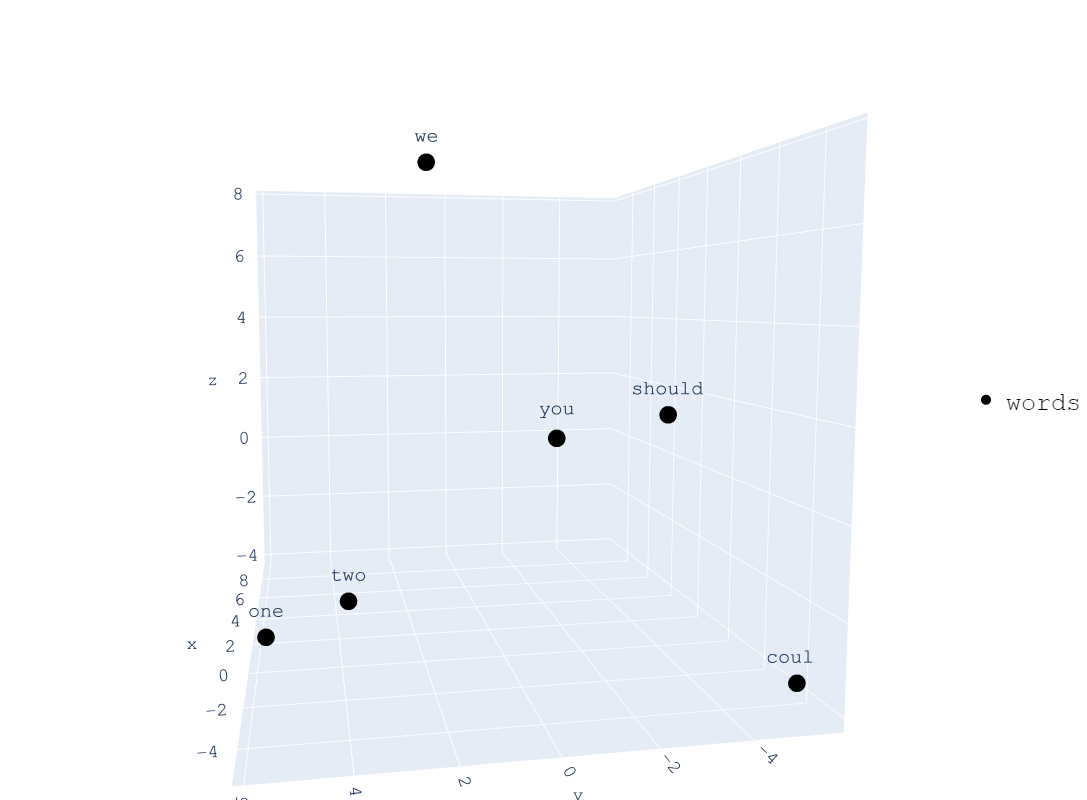

In [71]:
layout = go.Layout(
        margin = {'l': 0, 'r': 0, 'b': 0, 't': 0},
        showlegend=True,
        legend=dict(
        x=1,
        y=0.5,
        font=dict(
            family="Courier New",
            size=25,
            color="black"
        )),
        font = dict(
            family = " Courier New ",
            size = 15),
        autosize = False,
        width = 800,
        height = 800
        )


plot_figure = go.Figure(data = trace_data, layout = layout)
plot_figure.show()